<a href="https://colab.research.google.com/github/horasan/ml/blob/main/R_LER_TREASURY_FIXED_INCOME_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
%matplotlib inline
import plotly.graph_objects as go
import plotly.express as px
import scipy.stats as stats
from IPython.display import display, HTML
import math
sns.set_style('darkgrid')
pd.set_option('display.max_columns', None) # all the columns will be shown
pd.set_option('display.max_rows', 99) # 99 of the possible rows will be shown
import calendar
import datetime

In [2]:
#drive.mount('/content/drive')
#DRIVE_DATASET_PATH = "/content/drive/My Drive/Colab Notebooks/0_R_LER/TREASURY/"

#0) Functions

## f(x) = x ** 2

In [3]:
def x_kare(x):
  return x**2

print(x_kare(3))

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

x = np.linspace(-10, 10, 100)

#plt.plot(x, x_kare(x), color = "red")
#plt.show()

9


## def after_n_month(year, order_in_year, base_date):

In [4]:
def after_n_month(year, order_in_year, base_date, frequency_per_year):
  num_of_months = ((year - 1) + order_in_year*1/frequency_per_year)*12
  calculated_date = base_date + pd.DateOffset(months=num_of_months)
  return pd.Series([num_of_months, calculated_date])

## calculate_compounded_interest

In [5]:
# TODO: Document needed,
# TODO: There is no exception handling
def calculate_compounded_interest(X, m, r, t):
  """

  Args:
    X: amount
    m: number of payments per year
    r: rate
    t: duration in year

  Returns: compounded_interest

  """
  P_t = ((1 + r / m)**(t*m))*X
  return P_t

## get_equivalent_rate

In [6]:
# TODO: Document needed: P_t is the future value.
# TODO: There is no exception handling
def get_equivalent_rate(P_t, X, m, t):
  r = ((P_t / X)**(1/(t*m)) - 1)*m
  return r

## calculate_present_value

In [7]:
# TODO: Document needed,
# TODO: There is no exception handling
# total_return_amount: amount to be paind in the future, r: prevailing interest rate, m: frequency per year, t: duration (unit is year)
def calculate_present_value(total_return_amount, r, m, t):
  PV = total_return_amount / ((1 + r/m) ** (m*t))
  return PV

## print_bond_present_value_description

In [8]:
# TODO: Document needed,
# TODO: There is no exception handling

def print_bond_present_value_description(bond_pre_future_data):
  total_present_value = 0.0;
  for index, row in bond_pre_future_data.iterrows(): # for each row in the DataFrame
    total_present_value = total_present_value + row["present_value"]
    print("${:.2f}".format(row["coupon_value"]), " will be paid ", row["time"], " year(s) later. Present value of ", "${:.2f}".format(row["coupon_value"]), " is ", "${:.2f}".format(row["present_value"]))
  print("Present value of the bond is " +  "${:.2f}".format(total_present_value))



## get_formatted_amout

In [9]:
def get_formatted_amout(amount):
    return "${:.2f}".format(amount)

## get_actual_number_of_days_between

# New section

In [10]:
def get_actual_number_of_days_between(date1, date2):
    if(date1 > date2):
      return date1 - date2
    if(date2 > date1):
      return date2 - date1
    return 0

## get_bond_lifecyle

In [11]:
def get_bond_lifecycle(face_value: float, coupon_rate: float, duration_in_years: float) -> pd.DataFrame:
  """
  Returns DataFrame:
  Args:
    face_value: face value of the bond on the mature date
    coupon_rate: coupon rate (Same for all coupons)
    duration_in_years: duration of the bond in years (exact dates are not used)

  Returns:
    pandas.DataFrame
  """
  bond_life = pd.DataFrame(columns=["year", "cash_flow", "desc"])
  bond_life["year"] = np.arange(1, duration_in_years+1, 1)

  # all the streams has coupon values. But last payment must have the face value.
  bond_life["cash_flow"] = face_value * coupon_rate
  bond_life["desc"] = "c_p"

  # update the last payment with face value
  index_of_the_last_year = bond_life.query("year == @duration_in_years").index[0]
  bond_life.loc[index_of_the_last_year, "cash_flow"] = bond_life.loc[index_of_the_last_year, "cash_flow"] + face_value
  bond_life.loc[index_of_the_last_year, "desc"] = bond_life.loc[index_of_the_last_year, "desc"] + "+ f_v"

  return bond_life

## get_bond_lifecycle_with_frequency

In [12]:
def get_bond_lifecycle_with_frequency(face_value: float, coupon_rate: float, duration_in_years: float, frequency_per_year: int) -> pd.DataFrame:
  """
  Returns DataFrame:
  Args:
    face_value: face value of the bond on the mature date
    coupon_rate: coupon rate (Same for all coupons)
    duration_in_years: duration of the bond in years (exact dates are not used)
    frequency_per_year: number of payments per year
  Returns:
    pandas.DataFrame
  """
  bond_life = pd.DataFrame(columns=["pay_order", "year", "order_in_year",  "cash_flow", "desc"])

  total_number_of_payments = duration_in_years * frequency_per_year
  bond_life["pay_order"] = np.arange(1, total_number_of_payments + 1, 1)

  ## set year list
  year_list = []
  order_in_year_list = []

#  for a in range(duration_in_years):
#    #year_list.append(a+1)
#    #year_list.append(a+1)
#    #order_in_year_list.append(1)
#    #order_in_year_list.append(2)
#    year_list.extend([a+1, a+1]) # add multiple values
#    order_in_year_list.extend([1, 2]) # add multiple values

  for a in range(duration_in_years):
    #year_list.append(a+1)
    #year_list.append(a+1)
    #order_in_year_list.append(1)
    #order_in_year_list.append(2)
    for fre in range(frequency_per_year):
      year_list.append(a+1)
      order_in_year_list.append(fre+1) # add multiple values

  bond_life["year"] = year_list
  bond_life["order_in_year"] = order_in_year_list

  # all the streams has coupon values. But last payment must have the face value.
  bond_life["cash_flow"] = (face_value * coupon_rate) / frequency_per_year
  bond_life["desc"] = "cp"

  # update the last payment with face value
  index_of_the_last_payment = bond_life.query("year == @duration_in_years").index[frequency_per_year - 1]
  bond_life.loc[index_of_the_last_payment, "cash_flow"] = bond_life.loc[index_of_the_last_payment, "cash_flow"] + face_value
  bond_life.loc[index_of_the_last_payment, "desc"] = bond_life.loc[index_of_the_last_payment, "desc"] + " + f_v"

  return bond_life

## get_bond_lifecycle_with_frequency_2

In [13]:
def get_bond_lifecycle_with_frequency_2(face_value: float, coupon_rate: float, duration_in_years: float, frequency_per_year: int) -> pd.DataFrame:
  """
  Returns DataFrame:
  Args:
    face_value: face value of the bond on the mature date
    coupon_rate: coupon rate (Same for all coupons)
    duration_in_years: duration of the bond in years (exact dates are not used)
    frequency_per_year: number of payments per year
  Returns:
    pandas.DataFrame
  """
  bond_life = pd.DataFrame(columns=["pay_order", "year", "order_in_year",  "cash_flow", "desc"])

  total_number_of_payments = duration_in_years * frequency_per_year
  bond_life["pay_order"] = np.arange(1, total_number_of_payments + 1, 1)

  ## set year list
  year_list = []
  order_in_year_list = []

#  for a in range(duration_in_years):
#    #year_list.append(a+1)
#    #year_list.append(a+1)
#    #order_in_year_list.append(1)
#    #order_in_year_list.append(2)
#    year_list.extend([a+1, a+1]) # add multiple values
#    order_in_year_list.extend([1, 2]) # add multiple values

  for a in range(duration_in_years):
    #year_list.append(a+1)
    #year_list.append(a+1)
    #order_in_year_list.append(1)
    #order_in_year_list.append(2)
    for fre in range(frequency_per_year):
      year_list.append(a+1)
      order_in_year_list.append(fre+1) # add multiple values

  bond_life["year"] = year_list
  bond_life["order_in_year"] = order_in_year_list

  # all the streams has coupon values. But last payment must have the face value.
  bond_life["cash_flow"] = (face_value * coupon_rate) / frequency_per_year
  bond_life["desc"] = "cp"

  # update the last payment with face value
  index_of_the_last_payment = bond_life.query("year == @duration_in_years").index[frequency_per_year - 1]
  bond_life.loc[index_of_the_last_payment, "cash_flow"] = bond_life.loc[index_of_the_last_payment, "cash_flow"] + face_value
  bond_life.loc[index_of_the_last_payment, "desc"] = bond_life.loc[index_of_the_last_payment, "desc"] + " + f_v"

  return bond_life

## get_bond_lifecycle_with_exact_dates

In [14]:
def get_bond_lifecycle_with_exact_dates(face_value: float, coupon_rate: float, frequency_per_year: int, issue_date, maturity_date, day_count_convention) -> pd.DataFrame:
  """
  Returns DataFrame:
  Args:
    face_value: face value of the bond on the mature date
    coupon_rate: coupon rate (Same for all coupons)
    duration_in_years: duration of the bond in years (exact dates are not used) TO_BE_DELETED
    frequency_per_year: number of payments per year
    issue_date: Bond issue date
    maturity_date: Bond maturty date
  Returns:
    pandas.DataFrame
  """
  duration_in_years_x = maturity_date.year - issue_date.year
  bond_life = get_bond_lifecycle_with_frequency(face_value, coupon_rate, duration_in_years_x,frequency_per_year)

  bond_life[["after_n_months", "payment_date"]] = bond_life.apply(lambda row: after_n_month(row["year"], row["order_in_year"], issue_date,frequency_per_year) ,axis = 1)
  bond_life["before_payment_date"] = bond_life.apply(lambda row: row["payment_date"] - pd.DateOffset(months=1/frequency_per_year*12) ,axis = 1)
  bond_life["next_payment_date"] = bond_life.apply(lambda row: row["payment_date"] + pd.DateOffset(months=1/frequency_per_year*12) ,axis = 1)

  return bond_life

## get_bond_lifecycle_with_exact_dates_2

In [15]:
def get_bond_lifecycle_with_exact_dates_2(face_value: float, coupon_rate: float, frequency_per_year: int, issue_date, maturity_date, day_count_convention) -> pd.DataFrame:
  """
  Returns DataFrame:
  Args:
    face_value: face value of the bond on the mature date
    coupon_rate: coupon rate (Same for all coupons)
    duration_in_years: duration of the bond in years (exact dates are not used) TO_BE_DELETED
    frequency_per_year: number of payments per year
    issue_date: Bond issue date
    maturity_date: Bond maturty date
  Returns:
    pandas.DataFrame
  """
  duration_in_years_x = maturity_date.year - issue_date.year
  bond_life = get_bond_lifecycle_with_frequency(face_value, coupon_rate, duration_in_years_x,frequency_per_year)

  bond_life[["after_n_months", "payment_date"]] = bond_life.apply(lambda row: after_n_month(row["year"], row["order_in_year"], issue_date,frequency_per_year) ,axis = 1)
  bond_life["before_payment_date"] = bond_life.apply(lambda row: row["payment_date"] - pd.DateOffset(months=1/frequency_per_year*12) ,axis = 1)
  bond_life["next_payment_date"] = bond_life.apply(lambda row: row["payment_date"] + pd.DateOffset(months=1/frequency_per_year*12) ,axis = 1)

  return bond_life

## get_bond_lifecycle_for_observation_date: TODO!!!

day_count_convention' a gore hesaplama yapma isi eksik!!!!!

In [16]:
def get_bond_lifecycle_for_observation_date(face_value: float, coupon_rate: float, frequency_per_year: int, issue_date, maturity_date, day_count_convention, observation_date, yield_in: float) -> pd.DataFrame:
  """
  Returns DataFrame:
  Args:
    face_value: face value of the bond on the mature date
    coupon_rate: coupon rate (Same for all coupons)
    duration_in_years: duration of the bond in years (exact dates are not used) TO_BE_DELETED
    frequency_per_year: number of payments per year
    issue_date: Bond issue date
    maturity_date: Bond maturty date
  Returns:
    pandas.DataFrame
  """
  bond_life = get_bond_lifecycle_with_exact_dates(    face_value = face_value,    coupon_rate = coupon_rate,    frequency_per_year = frequency_per_year,    issue_date = issue_date,    maturity_date = maturity_date,    day_count_convention = "ACT/ACT")

  bond_life["status"] = bond_life.apply(
        lambda row: "UNPAID" if row["payment_date"] > observation_date else "PAID"
        ,axis = 1)

  bond_life["yield"] = yield_in

  bond_life["any_accured_int"] = bond_life.apply(
        lambda row: 1 if row["before_payment_date"] < observation_date < row["payment_date"] else 0
        ,axis = 1)

  bond_life["accured_int_amnt"] = bond_life.apply(
        lambda row: get_accured_interest_amount(row["before_payment_date"], observation_date, row["payment_date"], day_count_convention, row["cash_flow"]) if row["any_accured_int"] == 1 else 0
        ,axis = 1)
  bond_life["term_days"] = bond_life.apply(lambda row: (row["payment_date"] - row["before_payment_date"]).days  , axis = 1)

  bond_life["days_passed_in_term"] = bond_life.apply(lambda row: (row["payment_date"] - observation_date).days if row["any_accured_int"] == 1 else 0, axis = 1)

  current_period_row = bond_life.query("any_accured_int == 1")

  current_period_pay_order = current_period_row["pay_order"].iloc[0]

  payment_period_fraction = int(current_period_row["days_passed_in_term"].iloc[0]) / int(current_period_row["term_days"].iloc[0])

  payment_period_fraction = round(payment_period_fraction, 3)

  bond_life["payment_period_fraction"] = bond_life.apply(lambda row: (payment_period_fraction + int((row["pay_order"] - current_period_pay_order))) if observation_date < row["payment_date"] else 0, axis = 1)

  bond_life["dirty_price"] = bond_life.apply(lambda row: row["cash_flow"] / ((1 + (row["yield"] / frequency_per_year_1))**row["payment_period_fraction"]) if(row["payment_period_fraction"] > 0) else 0 ,axis = 1)

  bond_life["dirty_price"] = round(bond_life["dirty_price"], 2)

  dirty_price_1 = bond_life["dirty_price"].sum()

  accured_interest_1 = bond_life["accured_int_amnt"].sum()

  clean_price_1 = dirty_price_1 - accured_interest_1

 # face_value: float, coupon_rate: float, frequency_per_year: int, issue_date, maturity_date, day_count_convention, observation_date, yield_in: float
  over_all_info = {
      "face_value": face_value,
      "coupon_rate": coupon_rate,
      "frequency_per_year": frequency_per_year,
      "issue_date": issue_date,
      "maturity_date": maturity_date,
      "day_count_convention": day_count_convention,
      "yield": yield_in ,
      "observation_date": observation_date,
      "dirty_price": dirty_price_1,
      "accured_interest": accured_interest_1,
      "clean_price": clean_price_1
  }


  return bond_life , pd.Series(over_all_info)

## get_bond_lifecycle_with_observation_date_2

In [17]:
def get_bond_lifecycle_for_observation_date_2(
    issue_date,
    maturity_date,
    frequency_per_year: int,
    observation_date,
    face_value: float,
    coupon_rate: float,
    yield_in: float,
    day_count_convention = "ACT/ACT"
    ) -> pd.DataFrame:
  """
  Returns DataFrame:
  Args:
    issue_date: Bond issue date
    maturity_date: Bond maturity date
    frequency_per_year: number of payments per year
    observation_date: observation for bond valuation
    face_value: face value of the bond on the mature date
    coupon_rate: coupon rate (Same for all coupons)
    yield_in: not supported yet
    day_count_convention: day count convention. Supported versions:[ACT/ACT]
  Returns:
    pandas.DataFrame
  """

  # function
  duration_in_years = (maturity_date.year - issue_date.year) + 1

  bond_life = pd.DataFrame(columns=["pay_order", "year_order", "order_in_year", "reference_start_date", "term_start_date", "payment_date", "desc"])
  total_number_of_payments = duration_in_years * frequency_per_year
  term_duration_in_months = 12/frequency_per_year

  year_order = []
  order_in_year = []
  pay_order = []

  ##### TERMS AND PAYMENT DATES #####
  # create terms from last to first
  for a in range(duration_in_years):
    payment_order = duration_in_years - a
    for fre in range(frequency_per_year):
        year_order.append(duration_in_years - a)
        order_in_year.append(frequency_per_year - fre) # add multiple values
        pay_order.append(-1) # for now i am not sure about the first term



  bond_life["pay_order"] = pay_order
  bond_life["year_order"] = year_order
  bond_life["order_in_year"] = order_in_year

  bond_life["payment_date"] = bond_life.apply(lambda row:
                                              datetime.datetime(
                                                  (maturity_date.year - (duration_in_years - row["year_order"])), # year
                                                  (int(12/row["order_in_year"]) + maturity_date.month)%12, # month
                                                  maturity_date.day), #day
                                              axis = 1)

  bond_life = bond_life[bond_life["payment_date"] <= maturity_date] # trim possible extra rows
  bond_life = bond_life[bond_life["payment_date"] > issue_date] # trim possible extra rows
  bond_life = bond_life.reset_index(drop=True)
  bond_life["reference_start_date"] = bond_life.apply(lambda row: (row["payment_date"] - pd.DateOffset(months=(term_duration_in_months))) ,axis = 1)
  bond_life["term_start_date"] = bond_life.apply(lambda row: (row["payment_date"] - pd.DateOffset(months=(term_duration_in_months))) ,axis = 1)
  bond_life.iloc[(bond_life.shape[0] - 1), bond_life.columns.get_loc("term_start_date")] = issue_date # first term start date!

  bond_life["pay_order"] = bond_life.apply(lambda row: ((row["year_order"] * frequency_per_year) - row["order_in_year"]%frequency_per_year) ,axis = 1)

  bond_life["tot_days_in_term_for_interest"] = bond_life.apply(lambda row: (row["payment_date"] - row["reference_start_date"]).days ,axis = 1)
  bond_life["tot_days_in_term"] = bond_life.apply(lambda row: (row["payment_date"] - row["term_start_date"]).days ,axis = 1)


  #### INFO RELATED TO THE OBSERVATION DATE ####
  # payment status
  bond_life["status"] = bond_life.apply(lambda row: "UNPAID" if row["payment_date"] > observation_date else "PAID" ,axis = 1)
  bond_life["status"] = bond_life.apply(lambda row: "CURRENT" if (row["payment_date"] > observation_date >= row["term_start_date"] )  else row["status"]  ,axis = 1)

  # payment amount
  coupon_amount = face_value * coupon_rate / frequency_per_year

  bond_life["payment_amount"] = coupon_amount
  bond_life["desc"] = "cp"

  first_payment_reference_start_date = bond_life.iloc[(bond_life.shape[0] - 1), bond_life.columns.get_loc("reference_start_date")]
  first_payment_term_start_date = bond_life.iloc[(bond_life.shape[0] - 1), bond_life.columns.get_loc("term_start_date")]
  first_payment_term_payment_date = bond_life.iloc[(bond_life.shape[0] - 1), bond_life.columns.get_loc("payment_date")]

  first_term_payment_amount = coupon_amount

  if first_payment_reference_start_date < first_payment_term_start_date: # short coupon
    reference_term_day_count = (first_payment_term_payment_date - first_payment_reference_start_date).days
    first_term_day_count = (first_payment_term_payment_date - first_payment_term_start_date).days
    first_term_payment_amount = (first_term_day_count / reference_term_day_count) * coupon_amount
    first_term_desc = bond_life.iloc[(bond_life.shape[0] - 1), bond_life.columns.get_loc("desc")]
    bond_life.iloc[(bond_life.shape[0] - 1), bond_life.columns.get_loc("desc")] = first_term_desc + "|" + "SHORT COUPON"


  bond_life.iloc[(bond_life.shape[0] - 1), bond_life.columns.get_loc("payment_amount")] = first_term_payment_amount # first payment

  # last payment
  bond_life.iloc[0, bond_life.columns.get_loc("payment_amount")] = face_value + coupon_amount
  last_payment_desc = bond_life.iloc[0, bond_life.columns.get_loc("desc")]
  bond_life.iloc[0, bond_life.columns.get_loc("desc")] = last_payment_desc + "|" + "fv"

  # days passed in term
  bond_life["days_passed_in_term"] = bond_life.apply(lambda row:
  (observation_date - row["term_start_date"]).days if row["status"] == "CURRENT"
  else 0
  ,axis = 1)

  # accrued interest amount
  total_payment_amount = face_value * coupon_rate / frequency_per_year
  bond_life["accrued_interest"] = bond_life.apply(lambda row: get_accured_interest_amount(last_payment_date = row["term_start_date"], observation_date = observation_date, payment_date= row["payment_date"], day_count_convention = day_count_convention, amount = row["payment_amount"]) if row["status"] == "CURRENT" else 0, axis = 1)

  if (yield_in == None):
    print("yield is None: Present value is not calculated!")

  ##### TODO: Burada kaldim.
  current_term_index = bond_life.get(bond_life['status']=='CURRENT')

  print("observation_date:", observation_date)
  bond_life.sort_index(ascending = False)


  return bond_life

## get_present_value_with_yield

In [18]:
# TODO: Document needed,
# TODO: There is no exception handling
def get_present_value_with_yield(
    face_value: float,
    coupon_rate: float,
    duration_in_years: float,
    frequency_per_year: int,
    yield_rate: float
    ) -> pd.DataFrame:
  """
  Returns a present value for all cash flows
  Args:
    face_value: face value of the bond on the mature date
    coupon_rate: coupon rate (Same for all coupons)
    duration_in_years: duration of the bond in years (exact dates are not used)
    frequency_per_year: number of payments per year
    yield_rate: yield info
  Returns:
    pandas.DataFrame
  """

  bond_life = pd.DataFrame(columns=["payment_order", "year", "order_in_year",  "cash_flow", "PV_cash_flow", "desc"])

  total_number_of_payments = duration_in_years * frequency_per_year
  bond_life["payment_order"] = np.arange(1, total_number_of_payments + 1, 1)

  ## set year list
  year_list = []
  order_in_year_list = []

  for a in range(duration_in_years):
    #year_list.append(a+1)
    #year_list.append(a+1)
    #order_in_year_list.append(1)
    #order_in_year_list.append(2)
    for fre in range(frequency_per_year):
      year_list.append(a+1)
      order_in_year_list.append(fre+1) # add multiple values

  #print(year_list)

  bond_life["year"] = year_list
  bond_life["order_in_year"] = order_in_year_list

  # all the streams has coupon values. But last payment must have the face value.
  bond_life["cash_flow"] = (face_value * coupon_rate) / frequency_per_year
  #bond_life["desc"] = "coupon value"

  # update the last payment with face value
  index_of_the_last_payment = bond_life.query("year == @duration_in_years").index[frequency_per_year - 1]
  bond_life.loc[index_of_the_last_payment, "cash_flow"] = bond_life.loc[index_of_the_last_payment, "cash_flow"] + face_value
  #bond_life.loc[index_of_the_last_payment, "desc"] = bond_life.loc[index_of_the_last_payment, "desc"] + " + face value"

  # frequency_per_year! in fact this is not exactly correct.
  # Burada sanki her $125 yilda 4 parcada odenecek gibi hesapladim. Aslinda 3 ayda 1 odenecek sekilde olursa her birinin present value'su birbirinden farkli olacak.
  bond_life["PV_cash_flow"]   = bond_life.apply(lambda row: calculate_present_value(row["cash_flow"], yield_rate, frequency_per_year, row["year"]), axis=1)
  #print(bond_life["PV_cash_flow"].sum())
  return bond_life


## get_accured_interest_amount

In [19]:
def get_accured_interest_amount(last_payment_date, observation_date, payment_date, day_count_convention, amount):
  #print("amount:", amount)
  number_of_days_between_payments = payment_date - last_payment_date
  #print("number_of_days_between_payments:", number_of_days_between_payments)

  number_of_passed_days_after_last_payment_date = observation_date - last_payment_date
  #print("number_of_passed_days_after_last_payment_date:", number_of_passed_days_after_last_payment_date)
  #print("number_of_passed_days_after_last_payment_date / number_of_days_between_payments:", number_of_passed_days_after_last_payment_date / number_of_days_between_payments)
  accured_interest = number_of_passed_days_after_last_payment_date / number_of_days_between_payments * amount
  #print(accured_interest)

  return accured_interest

#1) Compounded Interest

**Example**: Calculate the future value of 5 years of a $15.000 investment at the risk free rate if the semiannually compounded rate for this term is 6%.
Do the same using a montly compounded rate of 5.5%.

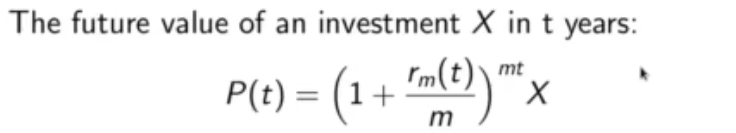



*   P(t) = Future Value
*   m = frequency (m times per year)
*   t = unit is year
*   X = initial investment






In [20]:
X = 15000
m = 2 # semiannually compounded
r = 0.06
t = 5 # years

P_t = (1 + r / m)**(t*m)*X
P_t # future value of X in the given parameters
print("P(t) for %", X, "m=", m, "r=", r , "t=", t,  "years: ", P_t)


P(t) for % 15000 m= 2 r= 0.06 t= 5 years:  20158.74569016183


In [21]:
X = 15000
m = 12 # montly compounded
r = 0.055
t = 5 # years

P_t = (1 + r / m)**(t*m)*X
P_t # future value of X in the given parameters
print("P(t) for %", X, "m=", m, "r=", r , "t=", t,  "years: ", P_t)

P(t) for % 15000 m= 12 r= 0.055 t= 5 years:  19735.55658804324


In [22]:
print(calculate_compounded_interest(15000, 2, 0.06, 5))
print(calculate_compounded_interest(15000, 12, 0.055, 5))

20158.74569016183
19735.55658804324


#2) Interest rate conversions

**Example**: If the annually compounded interest rate is 5%, what is the corresponding semiannualy compounded interest rate?

In [23]:
X = 1 # assume initial investment is $1
m = 1 # annually
r = 0.05
t = 1 # assume loan duration is 1 year

X_2 = 1 # same amount
m_2 = 2 # semi annually
r_2 = 0 # unknown
t_2 = 1 # same duration

P_t_1 = calculate_compounded_interest(X, m, r, t)
print(P_t_1)
print(get_equivalent_rate(P_t_1, 1, 2, 1))


1.05
0.04939015319191986


#3) Continuous Compounding: TODO


#4) Bonds and Discounted Cash Flow Analysis

## **Example** [1]

Calculate the price of a bond with a $1000 face value which pays annual coupon(interest) of 5%, and which matures in 4 years. Assume the prevailing interest rate (annually compounded) is 6% for all loan terms (flat term structure).

## Given bond information

In [24]:
coupon_rate = 5/100
t = 4
r = 6/100
face_value = 1000
m = 1 # annually payment

c1 = face_value * coupon_rate # 1 year later
t1 =1

c2 = face_value * coupon_rate # 2 years later
t2 =2

c3 = face_value * coupon_rate # 3 years later
t3 =3

c4 = (face_value * coupon_rate) + face_value # 4 years later
t4 =4



## Calculate present values for each payment

In [25]:
# initialize bond information.
bond_info = {
    'coupon_value': [c1, c2, c3, c4],
    'time': [t1, t2, t3, t4]
    }

# Create DataFrame
bond_data = pd.DataFrame(bond_info)

# add 'present value' data to dataframe
bond_data["present_value"] = bond_data.apply(lambda row: calculate_present_value(row["coupon_value"], r, m, row["time"]), axis=1)

bond_data

,coupon_value,time,present_value
0,50.0,1,47.169811
1,50.0,2,44.499822
2,50.0,3,41.980964
3,1050.0,4,831.698346


## Barplot of the payments

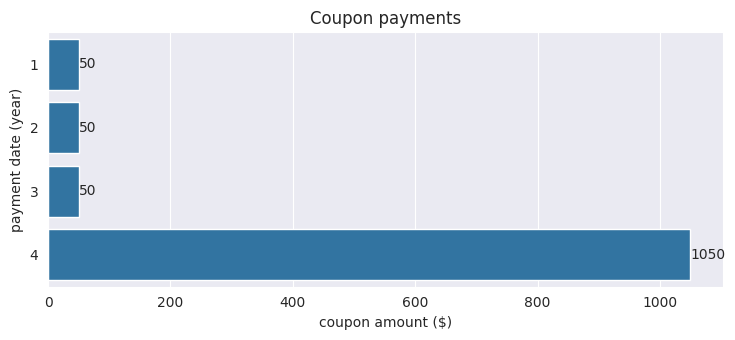

In [26]:
# Plot barplot with seaborn for the coupon payments
ax = sns.barplot(data = bond_data, y = "time", x = "coupon_value", orient='h')
ax.bar_label(ax.containers[0]) # TODO: amount' larin onune $ nasil ekleniyor?
ax.set(
    title='Coupon payments',
    xlabel='coupon amount ($)',
    ylabel='payment date (year)'
    )
#ax.set(xlabel='common xlabel', ylabel='common ylabel')
plt.show()

#type(ax.containers[0])
## "${:.2f}".format(a)

In [27]:
bond_data

,coupon_value,time,present_value
0,50.0,1,47.169811
1,50.0,2,44.499822
2,50.0,3,41.980964
3,1050.0,4,831.698346


## Print the bond life cycle

In [28]:
print_bond_present_value_description(bond_data)

$50.00  will be paid  1.0  year(s) later. Present value of  $50.00  is  $47.17
$50.00  will be paid  2.0  year(s) later. Present value of  $50.00  is  $44.50
$50.00  will be paid  3.0  year(s) later. Present value of  $50.00  is  $41.98
$1050.00  will be paid  4.0  year(s) later. Present value of  $1050.00  is  $831.70
Present value of the bond is $965.35


NOTE: Present value of the bond is $965.35

This amount of $965.35 is called DIRTY PRICE since this calculation does not take into account the accured interest!

## Scatter Plot of the present values of the payments

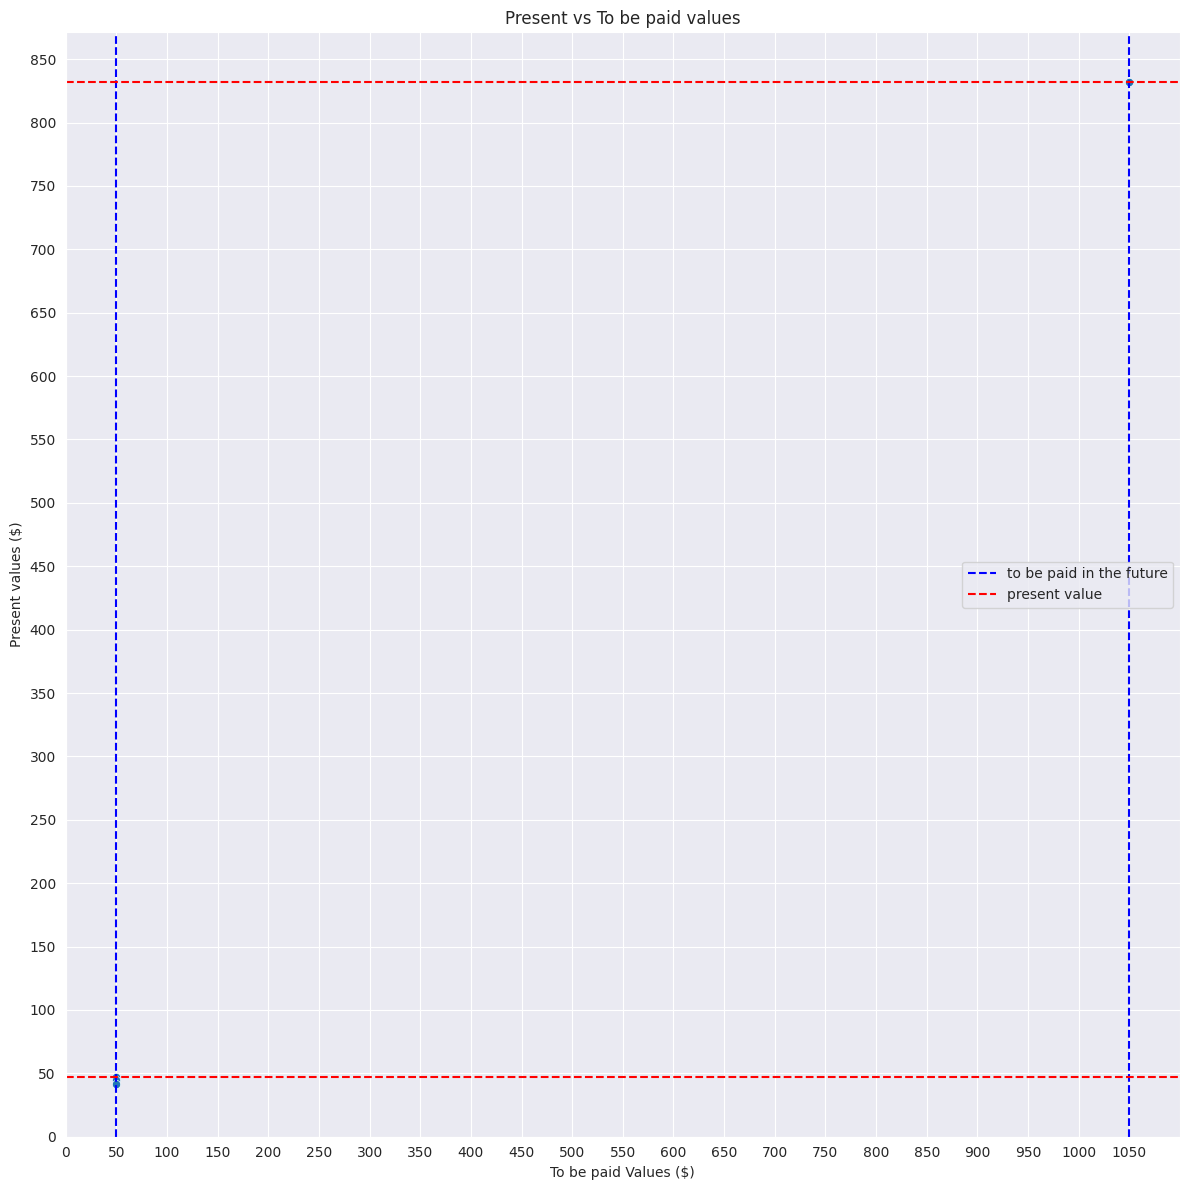

In [29]:
plt.figure(figsize=(12, 12))

# present value vs future value plot
ax = sns.scatterplot(data=bond_data, x="coupon_value",
                    y="present_value")
ax.set_xlim(0, 1100)
ax.set_xticks(np.arange(start=0, stop=1100, step=50))
ax.set_yticks(np.arange(start=0, stop=900, step=50))



ax.axvline(bond_data.iloc[0]["coupon_value"], color="blue", linestyle="--", label="to be paid in the future")
ax.axvline(bond_data.iloc[3]["coupon_value"], color="blue", linestyle="--")

ax.axhline(bond_data.iloc[0]["present_value"], color="red", linestyle="--", label="present value")
ax.axhline(bond_data.iloc[3]["present_value"], color="red", linestyle="--")

ax.set(
    title='Present vs To be paid values',
    xlabel='To be paid Values ($)',
    ylabel='Present values ($)'
    )
ax.legend(loc="center right")

plt.show()

# TODO: 50 ve 1050' leri x ekseninde nasil isaretleyecegim?
# TODO: PV(50) ve PV(1050)' leri y ekseninde nasil isaretleyecegim?

## Example [2]: Bond lifecycle

PS_CouponBond.pdf

Determine the payments and payment dates of a 5 year bond with a
face value of $50,000 and paying annual coupons of 4%. Plot the payments

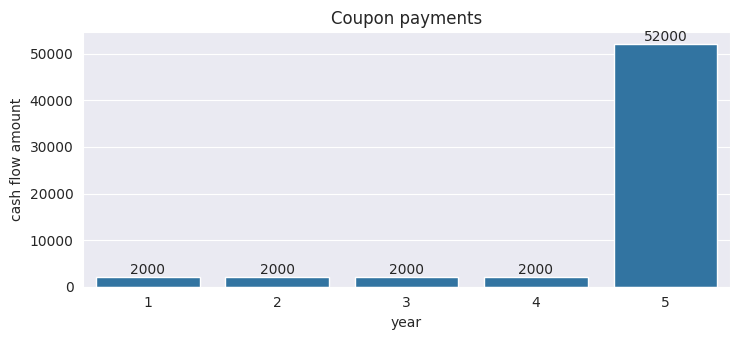

In [30]:
face_value_1 = 50000.0
duration_in_years_1 = 5
coupon_rate_1 = 4/100

b_l = get_bond_lifecycle(face_value= face_value_1, coupon_rate = coupon_rate_1, duration_in_years=duration_in_years_1)

ax = sns.barplot(data = b_l, x="year", y="cash_flow")

ax.set(
    title='Coupon payments',
    xlabel='year',
    ylabel='cash flow amount'
    )

ax.bar_label(ax.containers[0])

plt.show()


## Example [3]: Bond lifecycle

Determine the payments and payment dates of a 4 year bond with a
face value of $20,000 paying 7% coupons semiannually. Plot the payments.

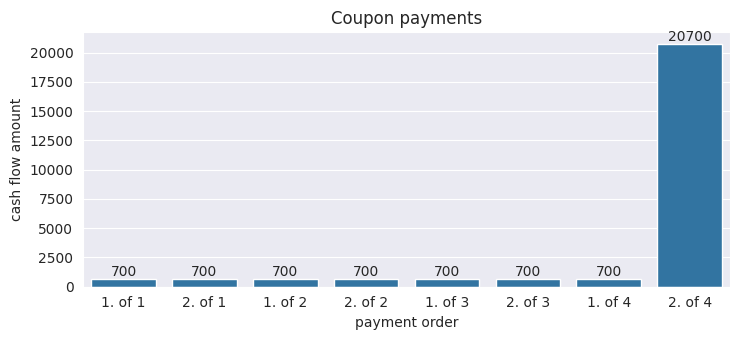

,pay_order,year,order_in_year,cash_flow,desc
0,1,1,1,700.0,cp
1,2,1,2,700.0,cp
2,3,2,1,700.0,cp
3,4,2,2,700.0,cp
4,5,3,1,700.0,cp
5,6,3,2,700.0,cp
6,7,4,1,700.0,cp
7,8,4,2,20700.0,cp + f_v


In [31]:
face_value_2 = 20000.0
duration_in_years_2 = 4
coupon_rate_2 = 7/100
requency_per_year_2 = 2

b_l = get_bond_lifecycle_with_frequency(face_value= face_value_2, coupon_rate = coupon_rate_2, duration_in_years=duration_in_years_2, frequency_per_year=requency_per_year_2)

# prepare plot
bar_label_list = []

for ind in b_l.index:
  bar_label_list.append(str(b_l.loc[ind, "order_in_year"]) + ". of " + (str(b_l.loc[ind, "year"])  ))

ax = sns.barplot(data = b_l, x=bar_label_list, y="cash_flow")

ax.set(
    title='Coupon payments',
    xlabel='payment order',
    ylabel='cash flow amount'
    )

ax.bar_label(ax.containers[0])
plt.show()

b_l

# 5) Present and Future Values of Cash Flow Streams

## Example[1]:
Consider a contract that pays

*   $ 1000  in 1 year,

*   $ 3000  in 2 years,

*   $ 5000  in 4 years.

Suppose the prevailing interest rate for all terms to maturity is 5%.
* [1] What is the future value of this contract at its maturity (in 4 years)? We will invest the money when we receive until the end of the contract.
* [2] How much should we pay to enter into this contract?


In [32]:
print("[1]")
#[1] What is the future value of this contract at its maturity (in 4 years)?
# We will invest the money when we receive until the end of the contract.

# for $1000 payment: FV = (4-1=3 years of compounding interest) + $1000
FV_1000 = calculate_compounded_interest(X=1000, m=1, r=5/100, t=3)
print("Future value of $1000: ", get_formatted_amout(FV_1000))

# for $3000 payment: FV = (4-2=2 years of compounding interest) + $3000
FV_3000 = calculate_compounded_interest(X=3000, m=1, r=5/100, t=2)
print("Future value of $3000: ", get_formatted_amout(FV_3000))

# for $5000 payment: FV = (4-4=0 years of compounding interest) + $5000
FV_5000 = calculate_compounded_interest(X=5000, m=1, r=5/100, t=0)
print("Future value of $5000: ",get_formatted_amout(FV_5000))

print("Total future value is the sum of each future values: ", get_formatted_amout(FV_1000+FV_3000+FV_5000))
print()

print("[2]")
# [2] How much should we pay to enter into this contract?
# so i need to find the present values of each future value.

# for $1000 payment will be done in 1 year
PV_1000 = calculate_present_value(total_return_amount=1000, m=1, t=1, r=5/100)
print("Present value of $1000 (to be paid in 1 year): ", get_formatted_amout(PV_1000))

# for $3000 payment will be done in 2 year
PV_3000 = calculate_present_value(total_return_amount=3000, m=1, t=2, r=5/100)
print("Present value of $3000 (to be paid in 2 year): ", get_formatted_amout(PV_3000))

# for $5000 payment will be done in 4 year
PV_5000 = calculate_present_value(total_return_amount=5000, m=1, t=4, r=5/100)
print("Present value of $5000 (to be paid in 5 year): ", get_formatted_amout(PV_5000))
print("Total present value is the sum of each present values:", get_formatted_amout(PV_1000 + PV_3000 + PV_5000))


[1]
Future value of $1000:  $1157.63
Future value of $3000:  $3307.50
Future value of $5000:  $5000.00
Total future value is the sum of each future values:  $9465.12

[2]
Present value of $1000 (to be paid in 1 year):  $952.38
Present value of $3000 (to be paid in 2 year):  $2721.09
Present value of $5000 (to be paid in 5 year):  $4113.51
Total present value is the sum of each present values: $7786.98


## Example[2]:

Suppose you intend to save

$5000 per year for the next 2 years,

$8000 per year for the next 2 years

after that, and finally $10000 in the fifth year.

If you are earning an interest rate of 4% in your savings account,

how much money will be in your account after 5 years?

   savings  when_to_save  year_in_savings_account
0     5000             1                        4
1     5000             2                        3
2     8000             3                        2
3     8000             4                        1
4    10000             5                        0


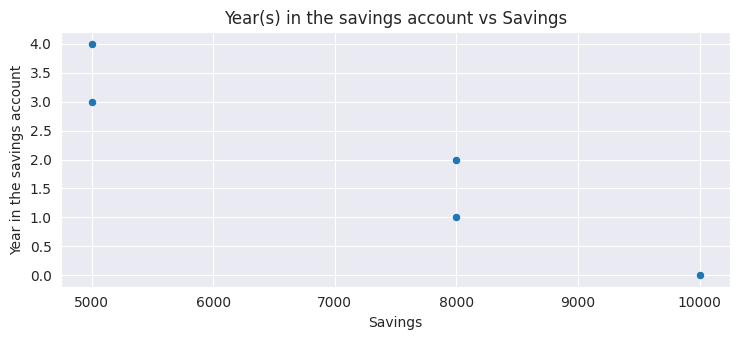

In [33]:
earning_data = {
    "savings": [5000, 5000, 8000, 8000, 10000],
    "when_to_save": [1, 2, 3, 4, 5] # after n year(s)
}

df_earning = pd.DataFrame(data=earning_data)


df_earning["year_in_savings_account"] = 5 - df_earning["when_to_save"]
print(df_earning)

ax = sns.scatterplot(data=df_earning, x = "savings", y="year_in_savings_account")

ax.set(
    title='Year(s) in the savings account vs Savings',
    xlabel='Savings',
    ylabel='Year in the savings account'
    )

plt.show()


In [34]:

r = 4/100
df_earning["future_value"] = df_earning.apply(lambda row: calculate_compounded_interest(row["savings"], 1, r, row["year_in_savings_account"]), axis=1)
print(df_earning)
print()
print("How much money will be in your account after 5 years?: ", get_formatted_amout(df_earning["future_value"].sum()))


   savings  when_to_save  year_in_savings_account  future_value
0     5000             1                        4     5849.2928
1     5000             2                        3     5624.3200
2     8000             3                        2     8652.8000
3     8000             4                        1     8320.0000
4    10000             5                        0    10000.0000

How much money will be in your account after 5 years?:  $38446.41


## Example [3]: Bond Pricing

C:\Users\rizaho\RIZA_HORASAN\Projects\how_to\treasury_concepts\FIXED_INCOME
PS_BondPricing.pdf

Suppose a 5 year government treasury bond with a \$12,000 nominal
value and paying annual coupon payments of 4% is currently trading for
\$10,000. How much should a 5 year government bond paying 4% coupons
annually with a \$40,000 face value be trading for. Ignore liquidity effects in
considering your answer.

In [35]:
nominal_value_1 = 12000 # $, face/par value
duration_1 = 5 # years
coupon_rate_1 = 4/100
current_trade_amount_1 = 10000 # $


nominal_value_2 = 12000 # $, face/par value
duration_2 = 5 # years
coupon_rate_2 = 4/100
current_trade_amount_2 = -1 # ?

# if other parameters are the same, then

# 12.0000 --> 10.000
# 40.000  --> current_trade_amount_2
current_trade_amount_2 = 10000 * 40000 / 12000
get_formatted_amout(current_trade_amount_2)

'$33333.33'

## 6) Coupon Bond Valuation: TODO. Bir tane daha ornek yap.

Fixed Income Analysis With Python Tools for Bonds and Money Market Instruments
24. ders 3.36 sn.

# 7) Bond pricing with Accrued Interest

## 7.1) Dirty (Full) Price and Clean Price

Clean Price = Full Price - Accrued Interest

The Accrued Interest is fraction of the next coupon payment (that has already been "earned").

Accrued Interest = (days elapsed since the last coupon payment) / (number of days betwen coupon payments) * c

* This definition is "rough" because the day count convension is assumed "actual/actual".

## 7.2) Day Count Conventions

Actual/Actual: Actual number of calendar days are used.

## Example (with Actual/Actual)

Suppose a bond maturing on June 15, 2022, with a face value of $100.000 and paying %8 coupons semiannually on June 15 and December 15 every year, is sold on August 15 2020. What is the accured interest using actual/actual day count?

In [36]:
calendar.monthrange(2024, 9)

calender_data = {
    "month" : np.arange(1, 13, 1),
    "number_of_days" : np.zeros((12,), dtype=int),
    "accrual_days": np.zeros((12,), dtype=int)
}

# create dataframe
calender_df = pd.DataFrame(data = calender_data, columns=["month", "number_of_days", "accrual_days"])

# add number of days for each month
calender_df["number_of_days"] = calender_df.apply(lambda row: calendar.monthrange(2024, row["month"])[1], axis=1 )

last_coupon_payment_date = datetime.datetime(2020, 6, 15)
sold_date = datetime.datetime(2020, 8, 15)
next_coupon_payment_date = datetime.datetime(2020, 12, 15)

calender_df


,month,number_of_days,accrual_days
0,1,31,0
1,2,29,0
2,3,31,0
3,4,30,0
4,5,31,0
5,6,30,0
6,7,31,0
7,8,31,0
8,9,30,0
9,10,31,0


In [37]:
# just to show the days in detail

last_payment_month = int(last_coupon_payment_date.strftime("%m"))
last_payment_day = int(last_coupon_payment_date.strftime("%d"))
number_of_days_in_last_payment_month = calender_df.query("month == @last_payment_month")["number_of_days"]

# calender_df.iloc[a, b] --> a:row index, b:column index of the dataframe!
calender_df.iloc[(last_payment_month-1), 2] = number_of_days_in_last_payment_month - last_payment_day

sold_month = int(sold_date.strftime("%m"))
sold_day = int(sold_date.strftime("%d"))

calender_df.iloc[last_payment_month:(sold_month-1), 2] = calender_df.iloc[last_payment_month:(sold_month-1)]["number_of_days"]
calender_df.iloc[(sold_month-1), 2] = sold_day
calender_df

,month,number_of_days,accrual_days
0,1,31,0
1,2,29,0
2,3,31,0
3,4,30,0
4,5,31,0
5,6,30,15
6,7,31,31
7,8,31,15
8,9,30,0
9,10,31,0


In [38]:
#last_coupon_payment_date = datetime.datetime(2020, 6, 15)
#sold_date = datetime.datetime(2020, 8, 15)
#next_coupon_payment_date = datetime.datetime(2020, 12, 15)

number_of_days_between_last_coupon_payment_and_sold_date = get_actual_number_of_days_between(sold_date, last_coupon_payment_date).days
print("number_of_days_between_last_coupon_payment_and_sold_date: ", int(number_of_days_between_last_coupon_payment_and_sold_date))

number_of_days_between_coupon_payment_dates = get_actual_number_of_days_between(last_coupon_payment_date, next_coupon_payment_date).days
print("number_of_days_between_coupon_payment_dates: ", int(number_of_days_between_coupon_payment_dates))

bond_face_amount = 100000
coupon_rate = 8/100
payment_frequency_per_year = 2
coupon_amount = coupon_rate * bond_face_amount / payment_frequency_per_year
print("coupon_amount:", get_formatted_amout(coupon_amount))

accured_interest = number_of_days_between_last_coupon_payment_and_sold_date / number_of_days_between_coupon_payment_dates * coupon_amount
print("accured_interest:", get_formatted_amout(accured_interest))

number_of_days_between_last_coupon_payment_and_sold_date:  61
number_of_days_between_coupon_payment_dates:  183
coupon_amount: $4000.00
accured_interest: $1333.33


## Example (with actual/actual)
Suppose \$ 1000000 goverment bond, maturing on June 30 2030, and paying 5% coupons annually is trading for $945.000 on September 15 2025. What is the accured interest and flat price on that date using actual/actual day convention.


In [39]:
matury_date = datetime.datetime(2030, 6, 30)
trade_date = datetime.datetime(2025, 9, 15)
last_payment_date = datetime.datetime(2025, 6, 30)

trade_amount = 945000 # bond price
face_value = 1000000
payment_frequency = 1 # annually
coupon_rate = 5/100

coupon_amount = coupon_rate * face_value / payment_frequency

num_of_days_bet_last_coupon_payment_and_sold_date = get_actual_number_of_days_between(trade_date, last_payment_date).days
print("num_of_days_bet_last_coupon_payment_and_sold_date: ", num_of_days_bet_last_coupon_payment_and_sold_date)
print("number of the days in a year (actual/actual): ", 365)
accrued_interest_amount = num_of_days_bet_last_coupon_payment_and_sold_date / 365 * coupon_amount
print("accrued_interest_amount: ", get_formatted_amout(accrued_interest_amount))

print("flat price = full price - accrued interest")
print("flat price:", get_formatted_amout(trade_amount - accrued_interest_amount))




num_of_days_bet_last_coupon_payment_and_sold_date:  77
number of the days in a year (actual/actual):  365
accrued_interest_amount:  $10547.95
flat price = full price - accrued interest
flat price: $934452.05


# 8) Bonds and Yields

## Yield calculation

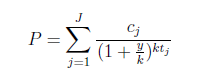

## Example[1]: Bond pricing (present value) with yield

Write out the
explicit formula for the special cases of semiannual compounding (k = 2),
quarterly compounding (k = 4), and monthly compounding (k = 12) for a
3 year bond paying annual coupon payments. What is the price of a 2 year
bond with a $10,000 nominal value paying 5% coupons annually, and with a
yield of 7% if this is an annually, semiannually, quarterly?

In [40]:
duration_x = 2 # years
nominal_value_x = 10000 # $
coupon_rate_x = 5/100
yield_rate_x = 7/100
coupon_frequency_1 = 1 # annually
coupon_frequency_2 = 2 # semiannually
coupon_frequency_3 = 4 # quarterly

cc = get_present_value_with_yield(face_value = nominal_value_x, coupon_rate = coupon_rate_x, duration_in_years = duration_x, frequency_per_year = coupon_frequency_3, yield_rate = yield_rate_x)
cc




,payment_order,year,order_in_year,cash_flow,PV_cash_flow,desc
0,1,1,1,125.0,116.619813,NaN
1,2,1,2,125.0,116.619813,NaN
2,3,1,3,125.0,116.619813,NaN
3,4,1,4,125.0,116.619813,NaN
4,5,2,1,125.0,108.801447,NaN
5,6,2,2,125.0,108.801447,NaN
6,7,2,3,125.0,108.801447,NaN
7,8,2,4,10125.0,8812.917178,NaN


## Example[2]: Bond pricing (present value) with yield

Consider a 3 year bond paying 4% coupons annually. Using some
normalized nominal value (like $100) sketch a plot of its price as a function
of yield over yields ranging from 1% to 10%. Do the same for a bond paying
2% coupons and 6% coupons.

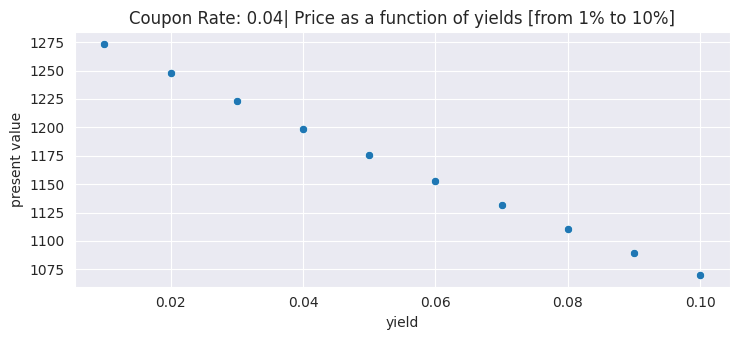

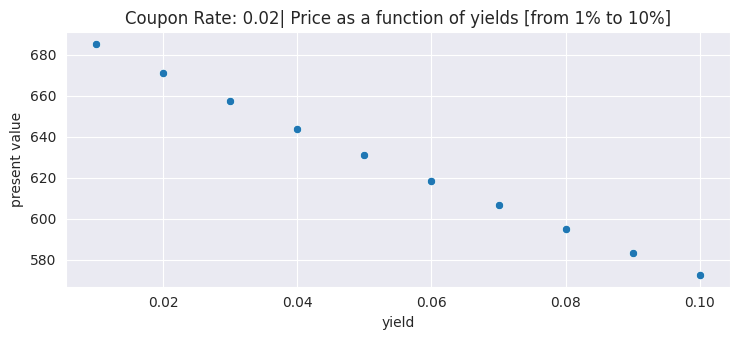

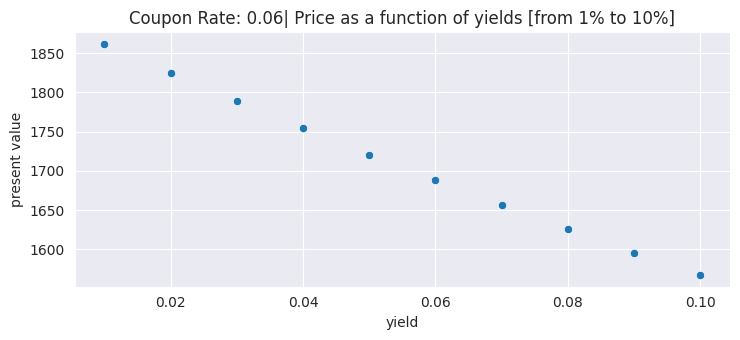

In [41]:
duration = 3 # years
coupon_rate = [4, 2, 6]
nominal_value = 100
frequency_per_year = 1 # annually
yield_list = range(1, 11, 1)

c_r_yield_pv = pd.DataFrame(columns=["coupon_rate", "yield", "pv"])

for c_r in coupon_rate:
  c_r_yield_pv = pd.DataFrame()
  for i in yield_list:
    yi = yield_list[i-1]/100
    #c_r = coupon_rate[0]/100
    bond_yi = get_present_value_with_yield(face_value = nominal_value, coupon_rate = c_r, duration_in_years = duration, frequency_per_year = frequency_per_year, yield_rate = yi)
    pv_total = bond_yi["PV_cash_flow"].sum()
    #print("yield:", yi, "coupon rate:", c_r, "present value:", pv_total)
    new_data = {"coupon_rate": c_r,
                "yield": yi,
                "pv": pv_total}
    new_data_df = pd.DataFrame([new_data])
    c_r_yield_pv = pd.concat([c_r_yield_pv, new_data_df], axis=0)


  # plot the data
  ax = sns.scatterplot(data = c_r_yield_pv, x="yield", y="pv")
  ax_title = 'Coupon Rate: ' + str(c_r/100) + "| Price as a function of yields [from 1% to 10%]"
  ax.set(
      title= ax_title,
      xlabel='yield',
      ylabel='present value'
      )
  plt.show()






## 8.1) Off Coupon Dates Yields and Present Value



## Example[3]: Present value(note: dirty price) on the off coupon date

Calculate the dirty price, accrued interest, and clean price of a bond
maturing in 4.5 years with a $50,000 face value and paying 3% coupons
annually if its current annually compounded yield is 5.5%.

In [42]:
off_coupon_bond = get_bond_lifecycle_with_frequency(face_value = 50000, coupon_rate = 3/100, duration_in_years = 5, frequency_per_year= 1)
off_coupon_bond

yield_1 = 5.5/100

off_coupon_bond_pv = get_present_value_with_yield(face_value = 50000, coupon_rate = 3/100, duration_in_years = 5, frequency_per_year= 1, yield_rate = yield_1)
off_coupon_bond_pv

off_coupon_bond_pv["passed_duration"] = [0.5, 0,0,0,0]

off_coupon_bond_pv["net_cash_flow"] = off_coupon_bond_pv.apply(lambda row: row["cash_flow"] * (1 - row["passed_duration"]), axis=1)
off_coupon_bond_pv
#print("Dirty Price:", off_coupon_bond_pv["net_pv"].sum())
#print("Accured Interest:", off_coupon_bond_pv["cash_flow"].sum() - off_coupon_bond_pv["net_pv"].sum())
#print("Clean Price:", off_coupon_bond_pv["cash_flow"].sum())

,payment_order,year,order_in_year,cash_flow,PV_cash_flow,desc,passed_duration,net_cash_flow
0,1,1,1,1500.0,1421.800948,NaN,0.5,750.0
1,2,2,1,1500.0,1347.678624,NaN,0.0,1500.0
2,3,3,1,1500.0,1277.420496,NaN,0.0,1500.0
3,4,4,1,1500.0,1210.825115,NaN,0.0,1500.0
4,5,5,1,51500.0,39404.419223,NaN,0.0,51500.0


In [43]:
off_coupon_bond_pv["pv_of_net_cash_flow"] = off_coupon_bond_pv.apply(lambda row: row["cash_flow"] / ((1 + yield_1)**(row["payment_order"] - 0.5) ), axis = 1)
off_coupon_bond_pv


,payment_order,year,order_in_year,cash_flow,PV_cash_flow,desc,passed_duration,net_cash_flow,pv_of_net_cash_flow
0,1,1,1,1500.0,1421.800948,NaN,0.5,750.0,1460.377151
1,2,2,1,1500.0,1347.678624,NaN,0.0,1500.0,1384.243745
2,3,3,1,1500.0,1277.420496,NaN,0.0,1500.0,1312.079379
3,4,4,1,1500.0,1210.825115,NaN,0.0,1500.0,1243.677136
4,5,5,1,51500.0,39404.419223,NaN,0.0,51500.0,40473.537136


In [44]:
dirty_price = off_coupon_bond_pv["pv_of_net_cash_flow"].sum()
print("dirty_price", get_formatted_amout(dirty_price))

accured_interest = 1500 * 0.5 # for the first payment
print("accured_interest", get_formatted_amout(accured_interest))

clean_price = dirty_price - accured_interest
print("clean_price", get_formatted_amout(clean_price))

dirty_price $45873.91
accured_interest $750.00
clean_price $45123.91


## Example[4]: Present value, off coupon date, yield, semi-annually bond

Find the dirty price, accrued interest and clean price of a 10 year semi-
annually paying bond issued on 6/15/2015 paying 5% coupons on 4/10/2021
if the bond's semiannually compounded yield on that date is 2%. Use a face
value of $150,000.

In [45]:
face_value_1 = 150000 #$
coupon_rate_1 = 5/100
frequency_per_year_1 = 2 #semi- annually paying
issue_date_1 = datetime.datetime(2015, 6, 15)
maturity_date_1 = issue_date_1 + pd.DateOffset(years = 10)
yield_1 = 2/100
observation_date_1 = datetime.datetime(2021, 4, 10)

bond2, over_all_info = get_bond_lifecycle_for_observation_date(
#bond2 = get_bond_lifecycle_for_observation_date(
    face_value = face_value_1,
    coupon_rate = coupon_rate_1,
    frequency_per_year = frequency_per_year_1,
    issue_date = issue_date_1,
    maturity_date = maturity_date_1,
    day_count_convention = "ACT/ACT",
    observation_date = observation_date_1,
    yield_in = yield_1
    )
bond2



,pay_order,year,order_in_year,cash_flow,desc,after_n_months,payment_date,before_payment_date,next_payment_date,status,yield,any_accured_int,accured_int_amnt,term_days,days_passed_in_term,payment_period_fraction,dirty_price
0,1,1,1,3750.0,cp,6.0,2015-12-15,2015-06-15,2016-06-15,PAID,0.02,0,0.00000,183,0,0.000,0.00
1,2,1,2,3750.0,cp,12.0,2016-06-15,2015-12-15,2016-12-15,PAID,0.02,0,0.00000,183,0,0.000,0.00
2,3,2,1,3750.0,cp,18.0,2016-12-15,2016-06-15,2017-06-15,PAID,0.02,0,0.00000,183,0,0.000,0.00
3,4,2,2,3750.0,cp,24.0,2017-06-15,2016-12-15,2017-12-15,PAID,0.02,0,0.00000,182,0,0.000,0.00
4,5,3,1,3750.0,cp,30.0,2017-12-15,2017-06-15,2018-06-15,PAID,0.02,0,0.00000,183,0,0.000,0.00
5,6,3,2,3750.0,cp,36.0,2018-06-15,2017-12-15,2018-12-15,PAID,0.02,0,0.00000,182,0,0.000,0.00
6,7,4,1,3750.0,cp,42.0,2018-12-15,2018-06-15,2019-06-15,PAID,0.02,0,0.00000,183,0,0.000,0.00
7,8,4,2,3750.0,cp,48.0,2019-06-15,2018-12-15,2019-12-15,PAID,0.02,0,0.00000,182,0,0.000,0.00
8,9,5,1,3750.0,cp,54.0,2019-12-15,2019-06-15,2020-06-15,PAID,0.02,0,0.00000,183,0,0.000,0.00
9,10,5,2,3750.0,cp,60.0,2020-06-15,2019-12-15,2020-12-15,PAID,0.02,0,0.00000,183,0,0.000,0.00


In [46]:
over_all_info

,0
face_value,150000
coupon_rate,0.05
frequency_per_year,2
issue_date,2015-06-15 00:00:00
maturity_date,2025-06-15 00:00:00
day_count_convention,ACT/ACT
yield,0.02
observation_date,2021-04-10 00:00:00
dirty_price,170349.85
accured_interest,2390.10989


## Example [5]: Government Bonds

On June 20, 2018, a German Bund maturing on March 15 2022, with a
e500,000 face value and paying 2% coupon annually has a quoted price (
at price) of e470,000. What is the accrued interest and dirty price.

In [47]:
observation_date = datetime.datetime(2018, 6, 20)
maturity_date = datetime.datetime(2022, 3, 15)
face_value = 500000
coupon_rate = 2/100
pay_freq = 1 #annually
quoted_price = 470000
issue_date = datetime.datetime(2017, 3, 15)

accrued_interest = -1
dirty_price = -1

bond6, other_values = get_bond_lifecycle_for_observation_date(face_value = face_value, coupon_rate = coupon_rate, frequency_per_year=pay_freq, issue_date = issue_date, maturity_date = maturity_date, day_count_convention="ACT/ACT", observation_date =observation_date, yield_in = 0)
bond6

accured_interest = other_values["accured_interest"]
print("accured_interest:", get_formatted_amout(accured_interest))

dirty_price = quoted_price + accured_interest
print("dirty_price:", get_formatted_amout(dirty_price))

bond6



accured_interest: $2657.53
dirty_price: $472657.53


,pay_order,year,order_in_year,cash_flow,desc,after_n_months,payment_date,before_payment_date,next_payment_date,status,yield,any_accured_int,accured_int_amnt,term_days,days_passed_in_term,payment_period_fraction,dirty_price
0,1,1,1,10000.0,cp,12.0,2018-03-15,2017-03-15,2019-03-15,PAID,0,0,0.000000,365,0,0.000,0.0
1,2,2,1,10000.0,cp,24.0,2019-03-15,2018-03-15,2020-03-15,UNPAID,0,1,2657.534247,365,268,0.734,10000.0
2,3,3,1,10000.0,cp,36.0,2020-03-15,2019-03-15,2021-03-15,UNPAID,0,0,0.000000,366,0,1.734,10000.0
3,4,4,1,10000.0,cp,48.0,2021-03-15,2020-03-15,2022-03-15,UNPAID,0,0,0.000000,365,0,2.734,10000.0
4,5,5,1,510000.0,cp + f_v,60.0,2022-03-15,2021-03-15,2023-03-15,UNPAID,0,0,0.000000,365,0,3.734,510000.0


## Example[6]: Government Bonds

On September 25, 2020 a US Treasury note maturing on July 15 2021
with a $20,000 face value paying 5% coupons is trading with a yield of 3.5%.
Take this as a semiannually compounded yield. What is the dirty price,
accrued interest and clean price?

In [48]:
observation_date = datetime.datetime(2020, 9, 25)
maturity_date = datetime.datetime(2021, 7, 15)
face_value = 20000
coupon_rate = 5/100
yield_in = 3.5/100
payment_frequency = 2 # 2 coupons per year

issue_date = datetime.datetime(2019, 7, 15) #assuming

bond7, all_info = get_bond_lifecycle_for_observation_date(
    face_value = face_value,
    coupon_rate = coupon_rate,
    frequency_per_year=payment_frequency,
    issue_date = issue_date,
    maturity_date = maturity_date,
    day_count_convention="ACT/ACT",
    observation_date =observation_date, yield_in = yield_in)

bond7
all_info

,0
face_value,20000
coupon_rate,0.05
frequency_per_year,2
issue_date,2019-07-15 00:00:00
maturity_date,2021-07-15 00:00:00
day_count_convention,ACT/ACT
yield,0.035
observation_date,2020-09-25 00:00:00
dirty_price,20430.43
accured_interest,195.652174


# 9) problem(366/365 vs 366/366)

In [49]:
bondd = get_bond_lifecycle_with_exact_dates(
    face_value = 500000,
    coupon_rate = 3.5/100,
    frequency_per_year = 2,
    issue_date = datetime.datetime(2024, 1, 16),
    maturity_date = datetime.datetime(2031, 2, 16),
    day_count_convention = "ACT/ACT")
bondd

,pay_order,year,order_in_year,cash_flow,desc,after_n_months,payment_date,before_payment_date,next_payment_date
0,1,1,1,8750.0,cp,6.0,2024-07-16,2024-01-16,2025-01-16
1,2,1,2,8750.0,cp,12.0,2025-01-16,2024-07-16,2025-07-16
2,3,2,1,8750.0,cp,18.0,2025-07-16,2025-01-16,2026-01-16
3,4,2,2,8750.0,cp,24.0,2026-01-16,2025-07-16,2026-07-16
4,5,3,1,8750.0,cp,30.0,2026-07-16,2026-01-16,2027-01-16
5,6,3,2,8750.0,cp,36.0,2027-01-16,2026-07-16,2027-07-16
6,7,4,1,8750.0,cp,42.0,2027-07-16,2027-01-16,2028-01-16
7,8,4,2,8750.0,cp,48.0,2028-01-16,2027-07-16,2028-07-16
8,9,5,1,8750.0,cp,54.0,2028-07-16,2028-01-16,2029-01-16
9,10,5,2,8750.0,cp,60.0,2029-01-16,2028-07-16,2029-07-16


In [50]:
issue_date = datetime.datetime(2024, 1, 16)
maturity_date = datetime.datetime(2031, 2, 15)
frequency_per_year = 2
observation_date = issue_date + pd.DateOffset(days=17) # 2024-02-15
face_value = 500000.0
coupon_rate = 3.5/100
day_count_convention = "ACT/ACT"
yield_in = None

bondd = get_bond_lifecycle_for_observation_date_2(
    issue_date = issue_date,
    maturity_date = maturity_date,
    frequency_per_year = frequency_per_year,
    observation_date = observation_date,
    face_value = face_value,
    coupon_rate = coupon_rate,
    yield_in=yield_in,
    day_count_convention = day_count_convention
)

bondd


yield is None: Present value is not calculated!
observation_date: 2024-02-02 00:00:00


,pay_order,year_order,order_in_year,reference_start_date,term_start_date,payment_date,desc,tot_days_in_term_for_interest,tot_days_in_term,status,payment_amount,days_passed_in_term,accrued_interest
0,15,8,1,2030-08-15,2030-08-15,2031-02-15,cp|fv,184,184,UNPAID,508750.000000,0,0.000000
1,14,7,2,2030-02-15,2030-02-15,2030-08-15,cp,181,181,UNPAID,8750.000000,0,0.000000
2,13,7,1,2029-08-15,2029-08-15,2030-02-15,cp,184,184,UNPAID,8750.000000,0,0.000000
3,12,6,2,2029-02-15,2029-02-15,2029-08-15,cp,181,181,UNPAID,8750.000000,0,0.000000
4,11,6,1,2028-08-15,2028-08-15,2029-02-15,cp,184,184,UNPAID,8750.000000,0,0.000000
5,10,5,2,2028-02-15,2028-02-15,2028-08-15,cp,182,182,UNPAID,8750.000000,0,0.000000
6,9,5,1,2027-08-15,2027-08-15,2028-02-15,cp,184,184,UNPAID,8750.000000,0,0.000000
7,8,4,2,2027-02-15,2027-02-15,2027-08-15,cp,181,181,UNPAID,8750.000000,0,0.000000
8,7,4,1,2026-08-15,2026-08-15,2027-02-15,cp,184,184,UNPAID,8750.000000,0,0.000000
9,6,3,2,2026-02-15,2026-02-15,2026-08-15,cp,181,181,UNPAID,8750.000000,0,0.000000


# 10) Repo (Repurchase Aggrements)

In [51]:
duration_in_years = (maturity_date.year - issue_date.year) + 1

bond_life = pd.DataFrame(columns=["pay_order", "year_order", "order_in_year", "reference_start_date", "term_start_date", "payment_date", "desc"])
total_number_of_payments = duration_in_years * frequency_per_year
term_duration_in_months = 12/frequency_per_year


In [52]:

repo_date = datetime.datetime(2019, 3, 1)
repo_keeping_days = 14
repo_maturity_date = repo_date + pd.DateOffset(days=repo_keeping_days)
repo_rate = 6/100
repo_rate_day_count = "ACT/360"
repo_amount = 50000000.0

#df2 = {'Name': 'Amy', 'Maths': 89, 'Science': 93}
#df = df._append(df2, ignore_index = True)

comp_a = pd.DataFrame(columns=["trn_order", "owner_id", "owner", "date", "asset", "amount", "formatted_amount", "desc"])
comp_a_on_repo_date = {
    "trn_order": 1,
    "owner_id": 1,
    "owner": "comp_a",
    "date": repo_date,
    "asset": "cash",
    "amount": repo_amount,
    "formatted_amount" : get_formatted_amout(repo_amount),
    "desc": "to bank_b"
}
comp_a_on_maturity_date = {
    "trn_order": 2,
    "owner_id": 1,
    "owner": "comp_a",
    "date": repo_maturity_date,
    "asset": "repo",
    "amount": -1,
    "formatted_amount" : get_formatted_amout(-1),
    "desc": "to bank_b"
}
comp_a = comp_a._append(comp_a_on_repo_date, ignore_index = True)
comp_a = comp_a._append(comp_a_on_maturity_date, ignore_index = True)

bank_b = pd.DataFrame(columns=["trn_order", "owner_id", "owner", "date", "asset", "amount", "formatted_amount","desc"])
bank_b_on_repo_date = {
    "trn_order": 1,
    "owner_id": 2,
    "owner": "bank_b",
    "date": repo_date,
    "asset": "repo",
    "amount": -1.0,
    "formatted_amount" : get_formatted_amout(-1),
    "desc": "to comp_a"
}
bank_b_on_maturity_date = {
    "trn_order": 2,
    "owner_id": 2,
    "owner": "bank_b",
    "date": repo_maturity_date,
    "asset": "cash",
    "amount": (repo_amount + repo_amount * repo_rate * ((repo_maturity_date - repo_date).days/360)) , # repo amount + interest
    "formatted_amount" : get_formatted_amout((repo_amount + repo_amount * repo_rate * ((repo_maturity_date - repo_date).days/360))),
    "desc": "to comp_a"
}
bank_b = bank_b._append(bank_b_on_repo_date, ignore_index = True)
bank_b = bank_b._append(bank_b_on_maturity_date, ignore_index = True)


all_actions = [comp_a, bank_b]
all_transactions = pd.concat(all_actions, ignore_index = True)
all_transactions["trn_order"] = np.arange(1, all_transactions.shape[0] + 1, 1)
all_transactions = all_transactions.reset_index(drop = True)

all_transactions.sort_values(by=['date', 'owner_id'])

<ipython-input-52-a925f22f22c2>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  comp_a = comp_a._append(comp_a_on_repo_date, ignore_index = True)
<ipython-input-52-a925f22f22c2>:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bank_b = bank_b._append(bank_b_on_repo_date, ignore_index = True)


,trn_order,owner_id,owner,date,asset,amount,formatted_amount,desc
0,1,1,comp_a,2019-03-01,cash,5.000000e+07,$50000000.00,to bank_b
2,3,2,bank_b,2019-03-01,repo,-1.000000e+00,$-1.00,to comp_a
1,2,1,comp_a,2019-03-15,repo,-1.000000e+00,$-1.00,to bank_b
3,4,2,bank_b,2019-03-15,cash,5.011667e+07,$50116666.67,to comp_a


# 11) Holding Peroid Returns

In [53]:
# TODO



# 12) Yield to maturity

## 12.1) Generating yield to maturity plot!

https://www.wallstreetprep.com/knowledge/yield-to-call-ytc/

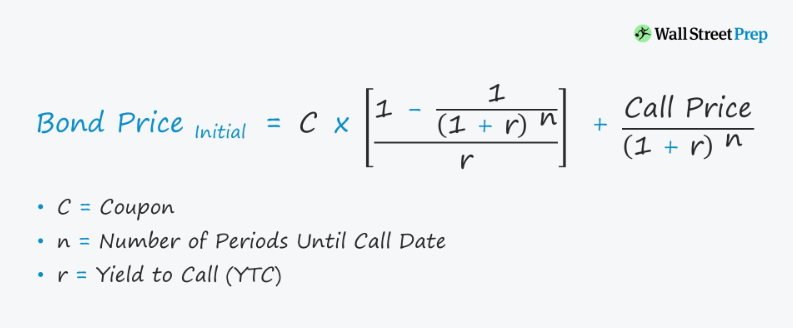

## Example[1]

 Let us assume a company XYZ Ltd has issued a bond having a face value of $100,000, carrying an annual coupon rate of 7% and maturing in 15 years. The prevailing market rate of interest is 9%.

In [78]:
def get_bond_price_in(coupon_amount_in, ytm_in, n_in , face_value_in):
  """
  Args:
    coupon_amount: coupon amount
    ytm: yield to maturity
    n: number of periods until call date
    face_value: face value

  Returns: compounded_interest
  """
  bond_price_2 = (coupon_amount_in) * ((1-((1+ytm_in)**(-1*n_in))) / ytm_in) + (face_value_in / (1+ytm_in)**n_in)

  #print("coupon_amount:",coupon_amount_in, "ytm:", ytm_in, "n:", n_in ,"face_value:", face_value_in)


  return bond_price_2

In [79]:
bond_current_price = -1
duration_in_years = 15
ytm_1 = 9 / 100
n_1 = 15
face_value_1 = 100000
coupon_rate_1 = 7/100
coupon_amount_1 = face_value_1 * coupon_rate_1

bond_price_1 = get_bond_price_in(coupon_amount_in = coupon_amount_1, ytm_in = ytm_1, n_in = n_1, face_value_in = face_value_1)
print("bond_price_1:", bond_price_1)


bond_price_1: 83878.6231402915


[ 0.          0.1010101   0.2020202   0.3030303   0.4040404   0.50505051
  0.60606061  0.70707071  0.80808081  0.90909091  1.01010101  1.11111111
  1.21212121  1.31313131  1.41414141  1.51515152  1.61616162  1.71717172
  1.81818182  1.91919192  2.02020202  2.12121212  2.22222222  2.32323232
  2.42424242  2.52525253  2.62626263  2.72727273  2.82828283  2.92929293
  3.03030303  3.13131313  3.23232323  3.33333333  3.43434343  3.53535354
  3.63636364  3.73737374  3.83838384  3.93939394  4.04040404  4.14141414
  4.24242424  4.34343434  4.44444444  4.54545455  4.64646465  4.74747475
  4.84848485  4.94949495  5.05050505  5.15151515  5.25252525  5.35353535
  5.45454545  5.55555556  5.65656566  5.75757576  5.85858586  5.95959596
  6.06060606  6.16161616  6.26262626  6.36363636  6.46464646  6.56565657
  6.66666667  6.76767677  6.86868687  6.96969697  7.07070707  7.17171717
  7.27272727  7.37373737  7.47474747  7.57575758  7.67676768  7.77777778
  7.87878788  7.97979798  8.08080808  8.18181818  8

<ipython-input-78-2af2bc156eb7>:11: RuntimeWarning: invalid value encountered in divide
  bond_price_2 = (coupon_amount_in) * ((1-((1+ytm_in)**(-1*n_in))) / ytm_in) + (face_value_in / (1+ytm_in)**n_in)


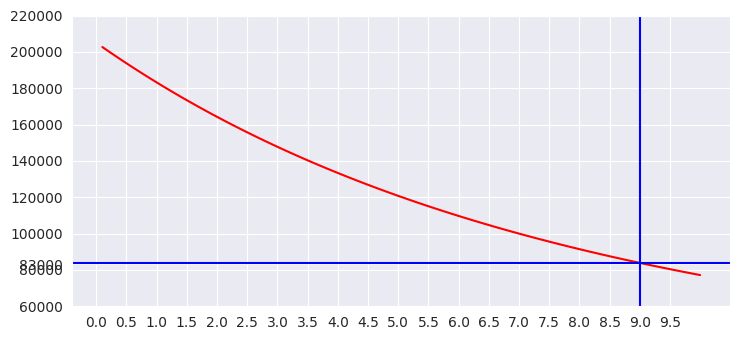

In [103]:

bond_current_price = -1
duration_in_years = 15
ytm_1 = 9 / 100
n_1 = 15
face_value_1 = 100000
coupon_rate_1 = 7/100
coupon_amount_1 = face_value_1 * coupon_rate_1

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

ytm_2 = np.linspace(0, 10, 100)

print(ytm_2)



plt.plot(ytm_2, get_bond_price_in(coupon_amount_in = coupon_amount_1, ytm_in = (ytm_2/100), n_in = n_1, face_value_in = face_value_1), color = "red")
plt.xticks(np.arange(min(0, min(ytm_2)), max(0, max(ytm_2)), 0.5))
plt.axhline(y = bond_price_1, color = 'b', linestyle = '-')
plt.axvline(x = ytm_1*100, color = 'b', linestyle = '-')
plt.yticks(list(plt.yticks()[0]) + [83000])
print(plt.yticks()[0] + [83000])
plt.show()